In [228]:
# Import relevant packages
import gurobipy as gp               # Gurobi Python API
from gurobipy import GRB            # Gurobi constants (e.g., GRB.MAXIMIZE)

import pandas as pd                 # DataFrames
import matplotlib.pyplot as plt     # Plotting
import numpy as np                  # Numerical operations and arrays

import data                         # Import data initialization functions   

In [229]:
def initialization_problem():
    """ 
    Initialize main parameters of the models.
    
    Parameters:
        n_players: number of storage players modeled in the Cournot game
        RES_factor: multiplying factor applied to a basic wind production profile
        storage_capacity_factor: multiplying factor applied to the required (estimated) total power rate to assess a total storage capacity sizing
        N: number of discrete power rate values (common for all storages)
        max_iter: maximum number of iteration for the Cournot game
    """

    return

In [230]:
## -- Initialization of parameters --
# Main changing parameters (for now constant)
tol = 1e-5                      # Nash equilibrium tolerance parameter
alpha_batt = 0.5                # Initial storage level (%)
min_eta = 0.85                  # Minimal storage round-trip efficiency
OC_default = 5                  # Default storage operating cost
RES_factor = 1.3                # Scaling factor for RES production
storage_capacity_factor = 5     # Ratio: Total storage capacity / Total storage power rate
N = 5                           # Discretization number for power outputs
max_iter = 200                  # Nash equilibrium maximum iteration number
max_n_players = 8

# Diverse parameters
np.random.seed(101)

# Set time horizon parameters
T = 24              # number of time periods
temps = range(T)    # time periods iterable


## -- Market data --
# Load demand curves
D = len(data.LOADS) # number of loads (10)

# Demand_price = pd.DataFrame({d: [round(data.load_bids[d],2)] * T for d in data.LOADS}).T
Demand_price_array = np.sort(np.random.rand(D))[::-1] * data.load_cost
Demand_price = pd.DataFrame({d: [round(Demand_price_array[d],2)] * T for d in range(D)}).T
Demand_price.columns = range(T)
Demand_price.index = data.LOADS

Demand_volume = pd.DataFrame({d: [round(data.load_profile[d,t],2) for t in data.TIMES] for d in data.LOADS}).T
Demand_volume_cumulative = Demand_volume.cumsum(axis=0)
Demand_volume = Demand_volume_cumulative

Demand_volume_total = Demand_volume.iloc[-1, :].values

max_dem = data.load_capacity
min_dem = 0

# Load RES profile
RES = np.array([data.generator_availability['W3'][t] * RES_factor * max_dem for t in range(1,T+1)])
Residual = -RES + Demand_volume_total


## -- Battery/Storage parameters --
Q_max_all = np.zeros(max_n_players)         # Maximum available power (MW)
OC_all = np.zeros(max_n_players)            # Marginal cost (€/MW)
E_max_all = np.zeros(max_n_players)         # Maximum battery level (MWh)
Q_all = [[] for _ in range(max_n_players)]  # List of possible power bids
Eta_all = np.zeros(max_n_players)           # Storage round-trip efficiency

# Storage requirement computation
Residual_corrected = np.where(Residual > 0, Residual / min_eta, Residual)   # Taking into account the round-trip efficiency when the battery discharge on the grid (=> need to discharge 100% + eta% energy to satisfy the corresponding demand)

Cummul_res_corr = np.cumsum(Residual_corrected)

# ..... if always surplus deficit, then offset by initial value to get full battery need
Local_cumul = Cummul_res_corr - np.minimum.accumulate(Cummul_res_corr)
                                # minimum of sliced list[:t]

PowerRating_req = np.max(np.abs(Residual_corrected))    # Minimum instantaneous power the storage system need to have to satisfy the demand at any time step > informs Q_max
PowerRating_req = int(np.round(PowerRating_req/100)*100)

# Capacity_req = np.max(Local_cumul)                      # Minimum total amount of energy the battery must store to satisfy the demand at any time step > informs E_max
# Capacity_req = int(np.floor(Capacity_req))
Capacity_req = PowerRating_req * storage_capacity_factor

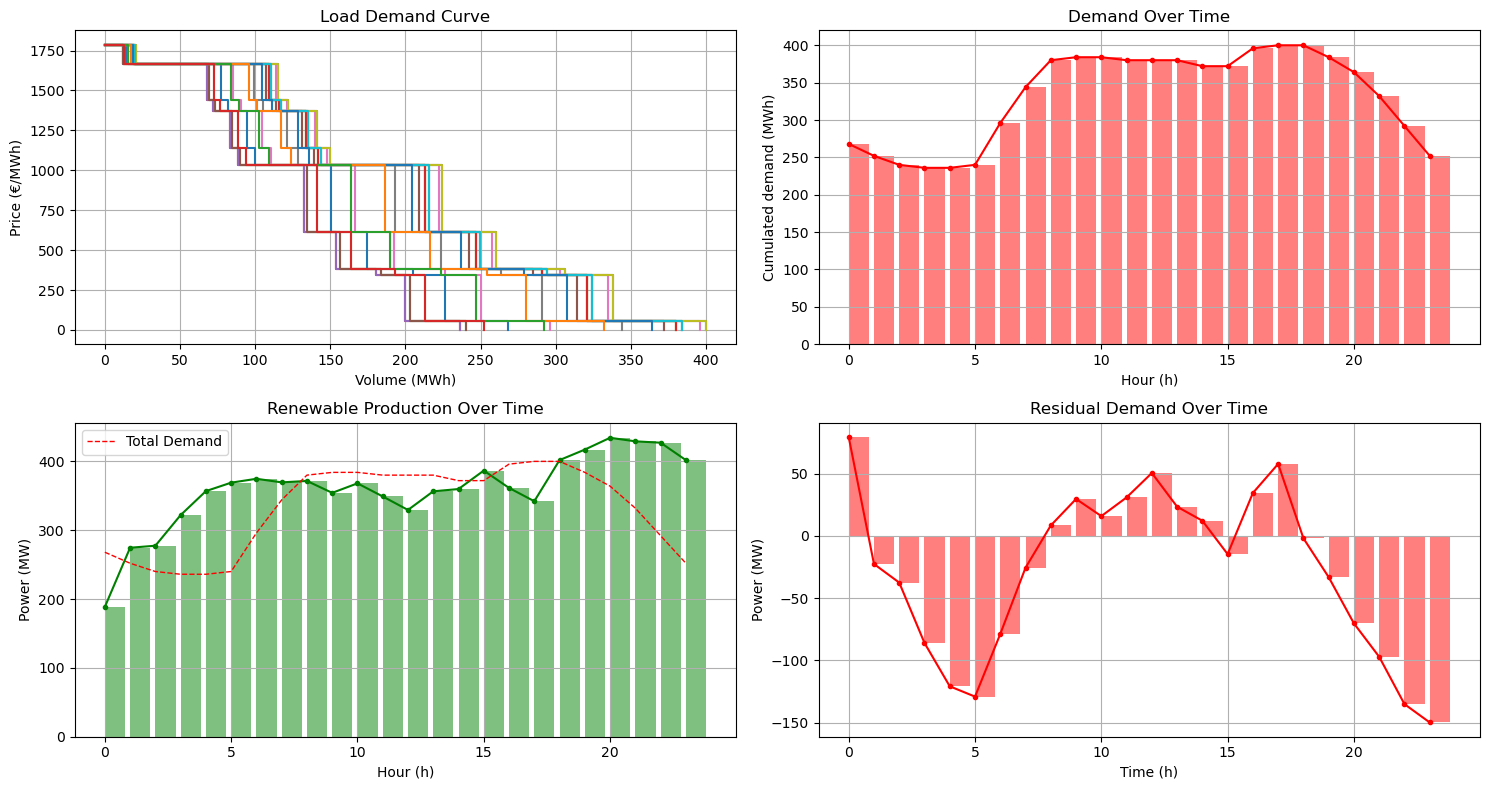

In [231]:
# Plotting of market data
market_data_fig = plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
for t in temps:
    plt.step(
        pd.concat([pd.Series([0], index=["BEG"]), Demand_volume.iloc[:,t], pd.Series([Demand_volume.iloc[-1,t]], index=["END"])]), 
        pd.concat([pd.Series([Demand_price.iloc[0,t]], index=["BEG"]), Demand_price.iloc[:,t], pd.Series([0], index=["END"])]), 
        label=f"Hour {t+1}")
plt.xlabel("Volume (MWh)")
plt.ylabel("Price (€/MWh)")
plt.title("Load Demand Curve")
plt.grid()
# plt.legend()

plt.subplot(2,2,2)
plt.plot(Demand_volume_total, color="red", marker='.')
plt.bar(x=temps, height=Demand_volume_total, color='red', alpha=0.5, align='edge')
plt.ylim(bottom=0)
plt.xlabel("Hour (h)")
plt.ylabel("Cumulated demand (MWh)")
plt.title("Demand Over Time")
plt.grid()

plt.subplot(2,2,3)
plt.plot(RES, color="green", marker='.')
plt.bar(x=temps, height=RES, color='green', alpha=0.5, align='edge')
plt.plot(Demand_volume_total, color='red', linestyle='--', linewidth=1, label="Total Demand")
plt.xlabel("Hour (h)")
plt.ylabel("Power (MW)")
plt.title("Renewable Production Over Time")
plt.legend()
plt.grid()

plt.subplot(2,2,4)
plt.plot(Residual, color="red", marker='.')
plt.bar(x=temps, height=Residual, color='red', alpha=0.5, align='edge')
plt.xlabel("Time (h)")
plt.ylabel("Power (MW)")
plt.title("Residual Demand Over Time")
plt.grid()

plt.tight_layout()
#plt.savefig("energy-data.png")

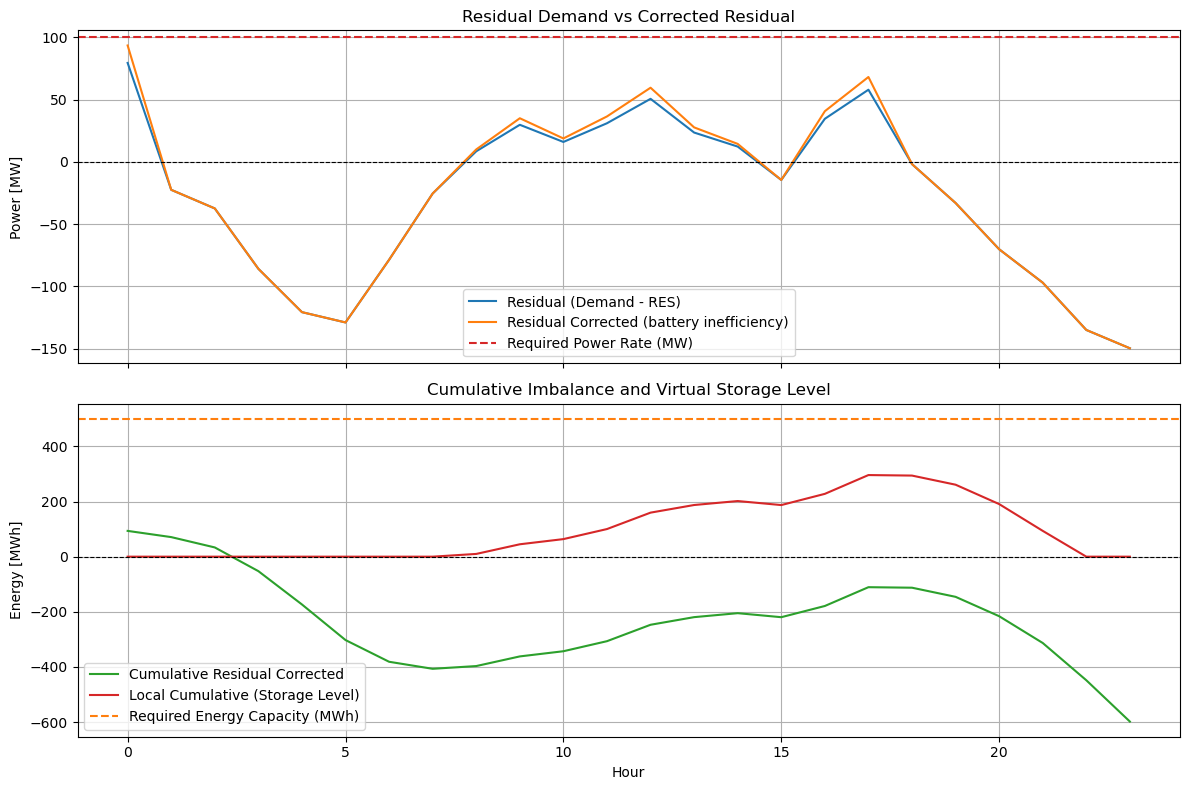

In [232]:
# Plotting battery requirements
battery_sizing_fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot 1: Residual and Residual Corrected
axs[0].plot(Residual, label='Residual (Demand - RES)', color='tab:blue')
axs[0].plot(Residual_corrected, label='Residual Corrected (battery inefficiency)', color='tab:orange')
axs[0].axhline(PowerRating_req, color='tab:red', linestyle='--', label='Required Power Rate (MW)')
axs[0].axhline(0, color='black', linestyle='--', linewidth=0.8)
axs[0].set_title('Residual Demand vs Corrected Residual')
axs[0].set_ylabel('Power [MW]')
axs[0].legend()
axs[0].grid(True)

# Plot 2: Cumulative and Local Cumulative
axs[1].plot(Cummul_res_corr, label='Cumulative Residual Corrected', color='tab:green')
axs[1].plot(Local_cumul, label='Local Cumulative (Storage Level)', color='tab:red')
axs[1].axhline(Capacity_req, color='tab:orange', linestyle='--', label='Required Energy Capacity (MWh)')
axs[1].axhline(0, color='black', linestyle='--', linewidth=0.8)
axs[1].set_title('Cumulative Imbalance and Virtual Storage Level')
axs[1].set_xlabel('Hour')
axs[1].set_ylabel('Energy [MWh]')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
#plt.savefig("storage-data.png")


In [233]:
## -- Final initialization for model run --
Demand_price = Demand_price.to_numpy()
Demand_volume = Demand_volume.to_numpy()

In [234]:
# Function containing the optimisation model
def model_run(q_ch_assumed, q_dis_assumed, player):

    # Initialization of model parameters
    # Data: RES[t], Demand_price[j,t], Demand_volume[j,t] - t in temps, j in range(D)
    forecasted_production = np.array([RES[t] + q_dis_assumed[t] - q_ch_assumed[t] for t in temps])

    if any(forecasted_production < 0):
        raise "Negative production: charging when no RES available"

    # Adjust demand curve as a price quota curve (based on residual demand) characterized by residual_demand_volume[j,t], residual_demand_price[j,t]
    residual_demand_volume = np.array([[Demand_volume[j,t] - forecasted_production[t] for t in temps] for j in range(D)])
    residual_demand_volume = np.where(residual_demand_volume < 0, 0, residual_demand_volume)

    residual_demand_price = np.zeros((D,T))
    for j in range(D):
        for t in temps:
            if residual_demand_volume[j,t] > 0:
                residual_demand_price[j,t] = Demand_price[j,t]
            else:
                residual_demand_price[j,t] = 0


    # Initialize price quota curve parameters
    step_min_demand = np.insert(residual_demand_volume[:-1,:], 0, 0, axis=0)
    step_max_additional_demand = np.array([[residual_demand_volume[j,t] - step_min_demand[j,t] for t in temps] for j in range(D)])

    # Used to constrain charging variables
    residual_production = np.array([forecasted_production[t] - Demand_volume[-1,t] for t in temps])
    residual_production = np.where(residual_production < 0, 0, residual_production)


    # Initiate optimization process
    model = gp.Model()
    model.Params.OutputFlag = 0
    # model.Params.NonConvex = 2  # Allow for quadratic constraints

    z_ch = model.addVars(temps, range(N), vtype=GRB.BINARY, name="z_ch")
    z_dis = model.addVars(temps, range(N), vtype=GRB.BINARY, name="z_dis")
    e = model.addVars(temps, lb=0, ub=E_max_all[player], name="e")
    u = model.addVars(temps, range(D), vtype=GRB.BINARY, name="u")
    b = model.addVars(temps, range(D), lb=0, name="b")
    q = model.addVars(temps, lb=0, ub=Q_max_all[player], name="q")

    # Define expression of variables
    q_ch = {t: gp.quicksum(Q_all[player][i] * z_ch[t, i] for i in range(N)) for t in temps}
    q_dis = {t: gp.quicksum(Q_all[player][i] * z_dis[t, i] for i in range(N)) for t in temps}
    revenue = {
        t:  gp.quicksum(residual_demand_price[j,t] * (b[t,j] + u[t,j] * step_min_demand[j,t]) for j in range(D)) - 
        OC_all[player] * (q_dis[t] + q_ch[t])
        for t in temps
    }

    # Linear objective function
    model.setObjective(gp.quicksum(revenue[t] for t in temps), GRB.MAXIMIZE)

    ## Storage feasible operating region / technical constraints
    # Energy storage intertemporal constraints: SOC update
    model.addConstr(e[0] == E_max_all[player] * alpha_batt + Eta_all[player] * q_ch[0] - q_dis[0])
    model.addConstrs(e[t] == e[t-1] + Eta_all[player] * q_ch[t] - q_dis[t] for t in range(1, T))
    model.addConstr(e[T-1] >= E_max_all[player] * alpha_batt)

    # Only one storage action possible: idle, charge or discharge at a fixed power rate
    model.addConstrs(gp.quicksum(z_ch[t, i] + z_dis[t, i] for i in range(N)) <= 1 for t in temps)

    ## Identification of the market price > linearization
    # Only a single active price level (corresponding to the market clearing price)
    model.addConstrs(gp.quicksum(u[t, j] for j in range(D)) == 1 for t in temps)

    # Identify amount of demand volume satisfied (for last demand step)
    model.addConstrs(b[t,j] <= u[t,j] * step_max_additional_demand[j,t]
                     for t in temps for j in range(D))
    
    # Constrain the discharging power to be equal to the satisfied demand ("balance equation")
    model.addConstrs(q[t] == q_dis[t] for t in temps)
    model.addConstrs(q[t] == gp.quicksum(b[t,j] + u[t,j] * step_min_demand[j,t] for j in range(D)) for t in temps)

    # In the case of residual production:
    # Market price = 0 because of data characteristics 
    # Charging is possible from residual RES
    model.addConstrs(q_ch[t] <= residual_production[t] for t in temps)
    
    model.addConstrs(q_dis[t] <= residual_demand_volume[-1,t] for t in temps)

    # Optimization of the model
    model.optimize()

    if model.status != GRB.OPTIMAL:
        print(f"Model status: {model.status}")

        if model.status == GRB.INFEASIBLE:
            print("Model is infeasible. Computing IIS...")
            model.computeIIS()
            model.write("infeasible.ilp")

        model.Params.OutputFlag = 1
        model.Params.LogFile = "gurobi_log.txt"
        model.write("myLP_model.lp")

        return None

    # Return outputs
    state = [[z_ch[t, i].X for i in range(N)] for t in temps], \
            [[z_dis[t, i].X for i in range(N)] for t in temps]
    
    u = [[u[t, j].X for j in range(D)] for t in temps]

    y = [[sum(u[t][k] for k in range(j+1, D)) for j in range(D-1)] for t in temps]

    CS = [sum((Demand_price[j, t] - Demand_price[j+1, t]) * (Demand_volume[j+1, t] - Demand_volume[0, t]) * y[t][j]
              for j in range(D-1)) for t in temps]

    price = [sum(residual_demand_price[j,t] * u[t][j] for j in range(D)) for t in temps]

    output = [[q_ch[t].getValue() for t in temps],
              [q_dis[t].getValue() for t in temps],
              [e[t].X for t in temps],
              price,
              [revenue[t].getValue() for t in temps],
              CS]
    

    return state, output, u

In [235]:
def arrays_are_equal(diff_table, a1, a2, n_players, tol=1e-7):
    if not a2:
        return False 

    diff = 0
    for p in range(n_players):
        a_new, a_old = np.array(a1[p]).flatten(), np.array(a2[p]).flatten()
        diff_p = np.sum(np.abs(a_new - a_old))
        diff = max(diff, diff_p)

    diff_table.append(diff)

    return diff_table

In [247]:
def nash_eq(q_ch_assumed_ini, q_dis_assumed_ini, n_players, tol=1e-7):

    ne = [[], []]
    state = {}
    output = {}
    u = {}
    profits = {p: [] for p in range(n_players)}
    diff_table = []     # Store the difference between model outputs for each iteration


    if n_players == 1:
        size_stor = [1]
    elif n_players == 2:
        size_stor = [1/3, 2/3]
    elif n_players == 4:
        size_stor = [0.1, 0.2, 0.3, 0.4]
    elif n_players == 6:
        size_stor = [0.05, 0.1, 0.1, 0.15, 0.25, 0.35]
    elif n_players == 8:
        size_stor = [0.05, 0.05, 0.1, 0.1, 0.1, 0.15, 0.2, 0.25]

    # Create summary dictionary for storage characteristics
    summary_data = {
        "Player": [],
        "OC": [],
        "Eta": [],
        "E_max": [],
        "Q_max": [],
        "Q_all": [],
    }

    iter = 0
    for player in range(n_players):
        OC_all[player] = OC_default
        Eta_all[player] = min_eta
        Q_max_all[player] = int(np.floor(PowerRating_req * size_stor[player] / 10) * 10)
        Q_all[player] = [round(Q_max_all[player] * (i / N),2) for i in range(1, N+1)]
        E_max_all[player] = int(np.floor(Capacity_req * size_stor[player] / 10) * 10)

        # Fill the summary dictionnary
        summary_data["Player"].append(chr(65 + player))
        summary_data["OC"].append(OC_all[player])
        summary_data["Eta"].append(Eta_all[player])
        summary_data["Q_max"].append(Q_max_all[player])
        summary_data["Q_all"].append(Q_all[player])
        summary_data["E_max"].append(E_max_all[player])
            
        # Initialize optimization model
        state[player], output[player], u[player] = model_run(q_ch_assumed_ini, q_dis_assumed_ini, player)

        # Store profits for later plots
        profits[player].append(sum(output[player][4][t] for t in temps))

    # DataFrame of storage characteristics
    summary_df = pd.DataFrame(summary_data)
    storage_summary_df = summary_df.set_index("Player")
    print("Storage characteristics:", "\n", storage_summary_df)

    # Store outputs of initialization models
    state_sys = [state[player] for player in range(n_players)]
    ne.append(state_sys.copy())

    if n_players == 1:
        return output, ne, iter, u, profits, storage_summary_df, diff_table

    for iter in range(1, max_iter):

        # Profit maximisation for each player
        for player in range(n_players):
            q_ch_assumed = [sum(output[p][0][t] for p in range(n_players) if p != player) for t in temps]
            q_dis_assumed = [sum(output[p][1][t] for p in range(n_players) if p != player) for t in temps]
            state[player], output[player], u[player] = model_run(q_ch_assumed, q_dis_assumed, player)
            
            # Store profits for later plots
            profits[player].append(sum(output[player][4][t] for t in temps))

        state_sys = [state[player] for player in range(n_players)]
        ne.append(state_sys.copy())

        diff_table = arrays_are_equal(diff_table, state_sys, ne[-2], n_players, tol)
        if diff_table[-1] < tol:
            break

    print("\nOptimization was successful.",f"\nIt converged in {iter} iterations.")
        
    return output, ne, iter, u, profits, storage_summary_df, diff_table

In [237]:
def export_results(n_players, output, ne, iter, u, profits):
    ## --- Export results ---

    # 1. Proad = Discharge - Charge for each player and time
    proad = [
        [output[player][1][t] - output[player][0][t] for t in temps]
        for player in range(n_players)
    ]

    # 2. Battery storage level per player
    batt = [
        [E_max_all[player] * alpha_batt] + [output[player][2][t] for t in temps]
        for player in range(n_players)
    ]

    # 3. Market price over time (assumed same for all players)
    market_price = [
        [output[player][3][t] for t in temps]
        for player in range(n_players)
    ]

    # 4. Revenue per player and time
    revenue = [
        [output[player][4][t] for t in temps]
        for player in range(n_players)
    ]

    # 5. Total profit per player
    profit_tot = [sum(revenue[player]) for player in range(n_players)]

    # 6. Total quantity offered to the market
    supply_total = [sum(proad[player][t] for player in range(n_players) if proad[player][t] >= 0) for t in temps]
    demand_total = [sum(proad[player][t] for player in range(n_players) if proad[player][t] < 0) for t in temps]
    proad_total = [supply_total[t] - demand_total[t] for t in temps]
    q_total = [RES[t] + proad_total[t] for t in temps]

    # # 7. Unmet demand
    # unmet_demand = sum(max(Demand_volume[-1, t] - q_total[t], 0) for t in temps)

    # # 8. Curtailed production
    # curtailed_prod = sum(max(-Demand_volume[-1, t] + q_total[t], 0) for t in temps)

    # # 9. Consumer Surplus
    # CS = [
    #     output[0][5][t] + (Demand_price[0, t] - market_price[t]) * Demand_volume[0, t]
    #     for t in temps
    # ]

    # # 10. Producer Surplus
    # PS = [
    #     sum(revenue[player][t] for player in range(n_players)) + 
    #     RES[t] * market_price[t]
    #     for t in temps
    # ]

    # # 11. Social Welfare
    # SW = sum(CS) + sum(PS)

    return proad, batt, market_price, revenue, profit_tot, supply_total, demand_total, proad_total, q_total, profits

In [238]:
def plot_results(n_players, diff_table, results_tuple):
    
    proad, batt, market_price, revenue, profit_tot, \
    supply_total, demand_total, proad_total, q_total, \
    profits = results_tuple
    
    ## --- Plots ---
    result_fig = plt.figure(figsize=(15,8))
    temps_np = np.array(temps)
    temps_with_zero_np = np.array([t for t in temps] + [T])


    # 1. Market Price Plot
    plt.subplot(2,2,1)

    values_to_show = [p for p in market_price[0] if p > 0]  # assuming market price has converged for each player

    for player in range(n_players):
        plt.step(temps_np, market_price[player], where='post')
    for p in values_to_show:
        plt.axhline(y=p, linestyle='--', color='gray', linewidth=1)
        plt.text(x=temps_np[-1]+1.5, y=p + 0.5, s=f'y = {p}', color='black', ha='left', va='bottom')
    plt.xlabel("Time (h)")
    plt.ylabel("Market Price (€/MWh)")
    plt.title("Market Price Over Time")
    plt.grid(True)


    # 2. Production and SoC per Player
    # Ax 1 for energy storage levels, ax 2 for energy storage discharging/charging power
    ax1 = plt.subplot(2,2,3) 

    for player in range(n_players):
        ax1.plot(temps_with_zero_np, batt[player], label=f"SoC for Player {player + 1}")
    ax1.set_ylim(bottom=0)  # top=max(E_max_all)
    ax1.set_xlabel("Time (h)")
    ax1.set_ylabel("Battery State of Charge (MWh)")
    ax1.legend(loc="upper left")
    ax1.set_title("Battery Cycle")

    ax2 = ax1.twinx()
    for player in range(n_players):
        ax2.step(temps_with_zero_np, proad[player] + [proad[player][-1]], where="post", label=f"Supply from Player {player + 1}", linestyle='--', linewidth=0.9)
    ax2.axhline(y=0, color='black', linewidth=1)
    ax2.set_ylabel('Power [MW]')
    ax2.legend(loc='upper right')
    ax2.grid()
    # fig.text(0.5, 0.01, "Player Production = Discharge - Charge Over Time", ha="center")


    # 3. Market Clearing View
    plt.subplot(2,2,2)

    plt.step(temps_with_zero_np, np.append(Demand_volume[-1, :], Demand_volume[-1, -1]), label="Demand", where='post', color='red', linestyle='--') 
    plt.bar(temps_np+0.5, RES, label="RES Production", color='green')
    plt.bar(temps_np+0.5, supply_total, label="Total Supply from Players", color='blue', bottom=RES)
    plt.bar(temps_np+0.5, demand_total, label="Total Demand from Players", color='blue', alpha=0.7, bottom=0)
    plt.xlabel("Time (h)")
    plt.ylabel("Power (MW)")
    bottom, top = plt.ylim()
    plt.ylim(top=top+20)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 0.2))
    plt.title("Market Clearing: Supply vs Demand Over Time")


    # # 4. Summary Bars for Unmet Demand and Curtailment
    # plt.subplot(2,2,4)

    # plt.bar(["Unmet Demand", "Curtailed Production"], [unmet_demand, curtailed_prod], color=["orange", "purple"])
    # plt.title("Total Unmet Demand and Curtailed Production")
    # plt.ylabel("Energy (MWh)")


    # 5. Summary Bars
    plt.subplot(2,2,4)

    labels = [f"Player {p+1} Profit" for p in range(n_players)]
    labels_bis = labels + ["Consumer Surplus", "Producer Surplus", "Social Welfare"]
    container = plt.bar(x=labels, height=profit_tot)
    plt.bar_label(container, [f"{round(p)} €" for p in profit_tot])
    plt.ylim(top=1.1*max(profit_tot))
    plt.title("Player Profits after Optimization")

    plt.tight_layout()


    # 6. Nash Equilibrium Result
    convergence_fig = plt.figure(figsize=(15,8))
    x = range(1, len(profits[0]) + 1)

    plt.subplot(2,2,1)
    plt.plot(x[1:], diff_table, label="Max Change per Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Computed Difference")
    # plt.yscale("log")
    plt.xticks(np.arange(min(x)+1, max(x)+1, 1))  # Set x ticks to integers
    plt.title("Cournot Iteration Convergence Plot")
    plt.grid(True)
    plt.legend()

    plt.subplot(2,2,2)
    for player in range(n_players):
        plt.plot(x, profits[player], label=f"Player {player+1} Profit Over Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Profit (€)")
    plt.title("Profit Evolution over Cournot Iteration")
    plt.ylim(bottom = 0)
    plt.grid(True)
    plt.legend()

    return result_fig, convergence_fig

In [239]:
def main(n_players):

    # Setting values to initialize the run
    q_ch_assumed_ini = [0 for _ in temps]
    q_dis_assumed_ini = [0 for _ in temps]

    # Run Cournot game for profit maximization of each independent player
    output, ne, iter, u, profits, storage_summary_df, diff_table = nash_eq(q_ch_assumed_ini, q_dis_assumed_ini, n_players)

    # Export and compute results
    results_tuple = export_results(n_players, output, ne, iter, u, profits)

    # Plot those results
    result_fig, convergence_fig = plot_results(n_players, diff_table, results_tuple)



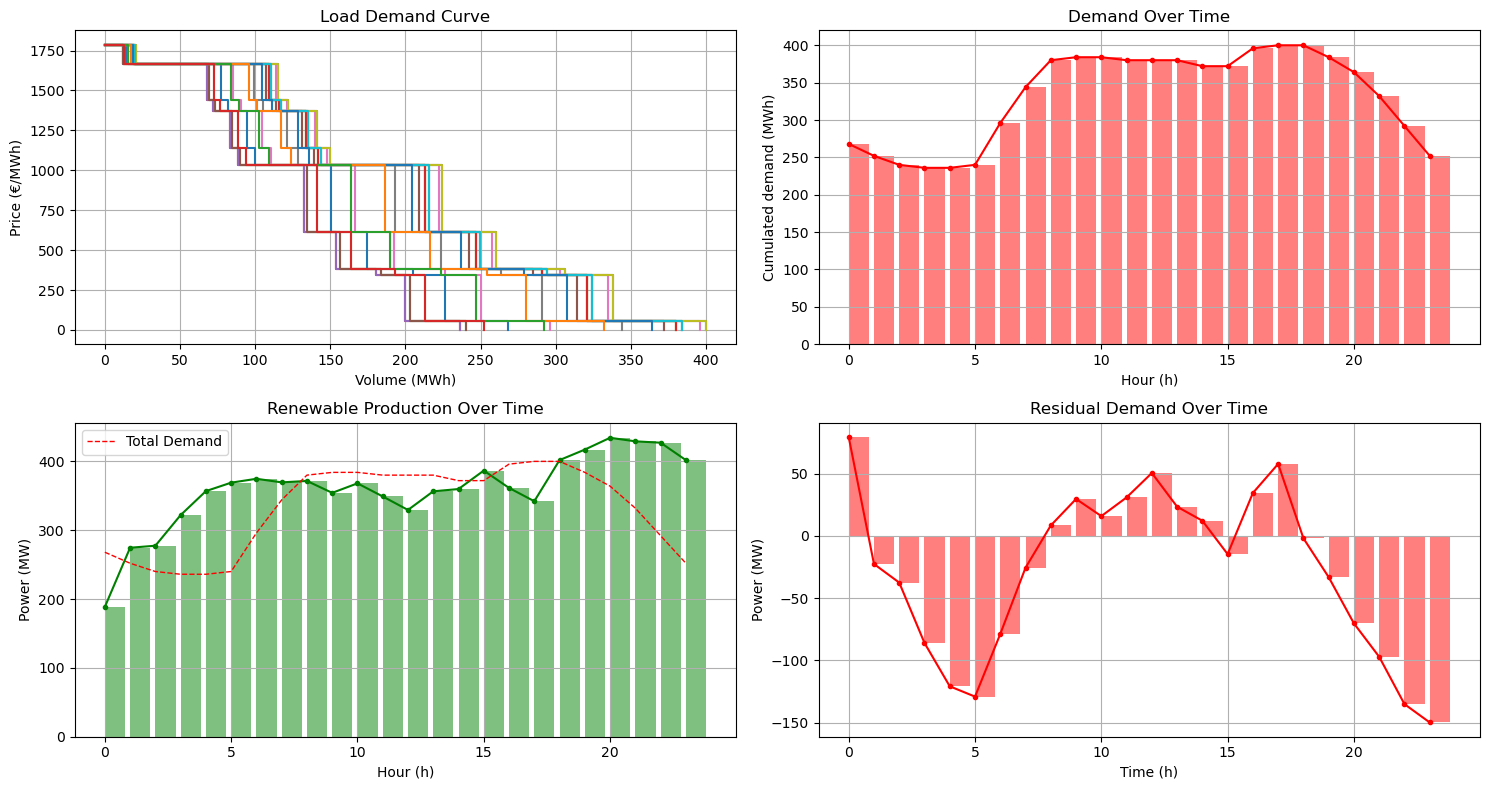

In [240]:
market_data_fig

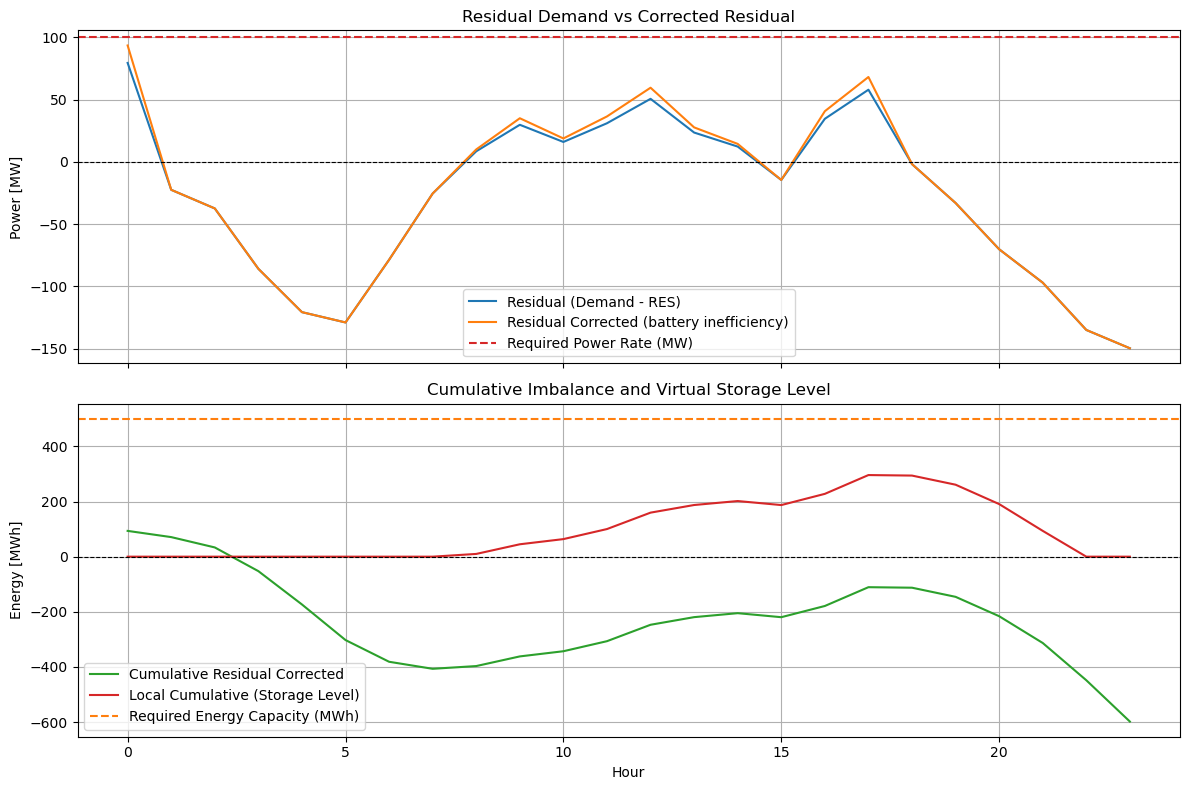

In [241]:
battery_sizing_fig

Storage characteristics: 
          OC   Eta  E_max  Q_max                            Q_all
Player                                                          
A       5.0  0.85  500.0  100.0  [20.0, 40.0, 60.0, 80.0, 100.0]


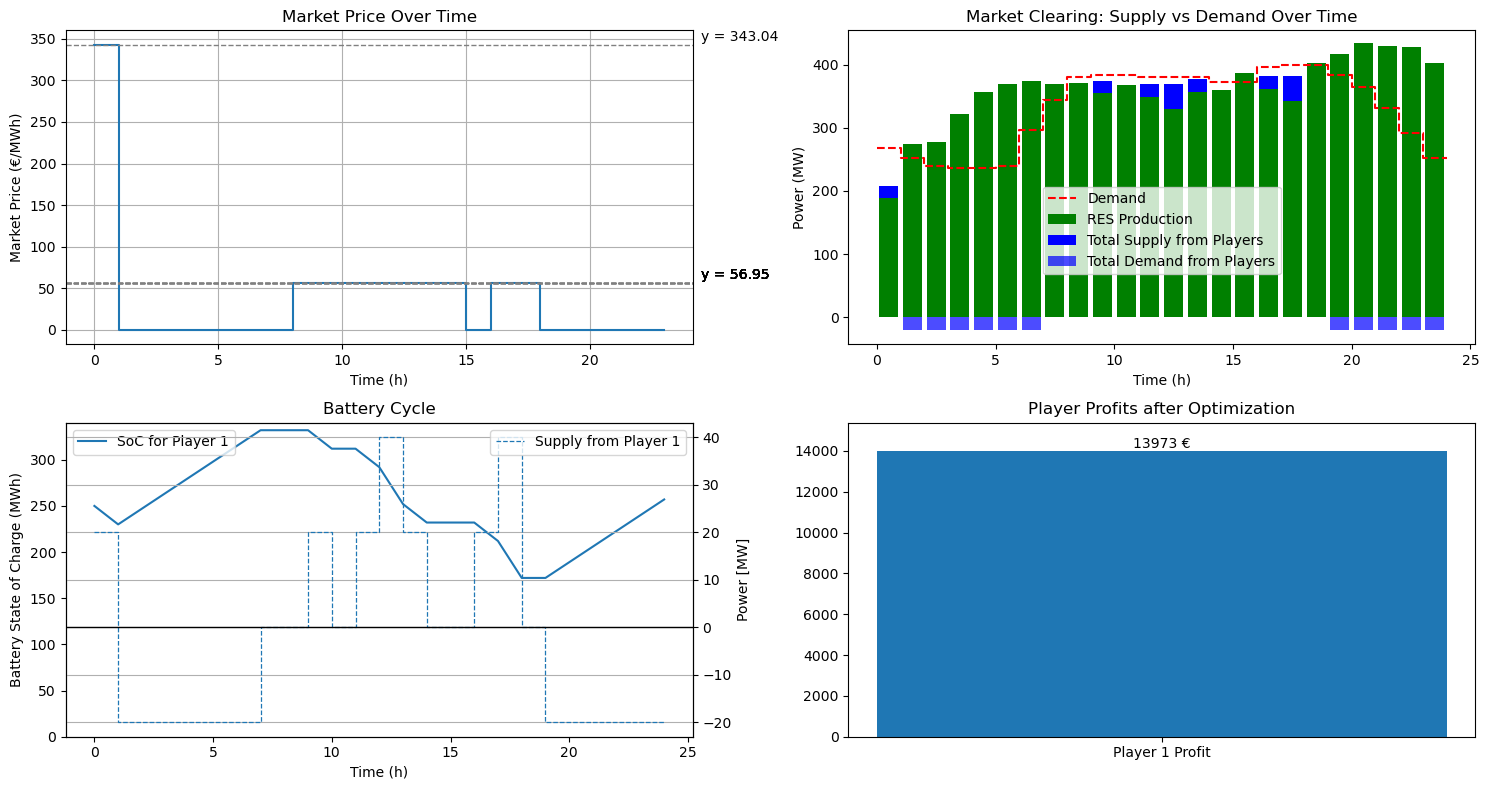

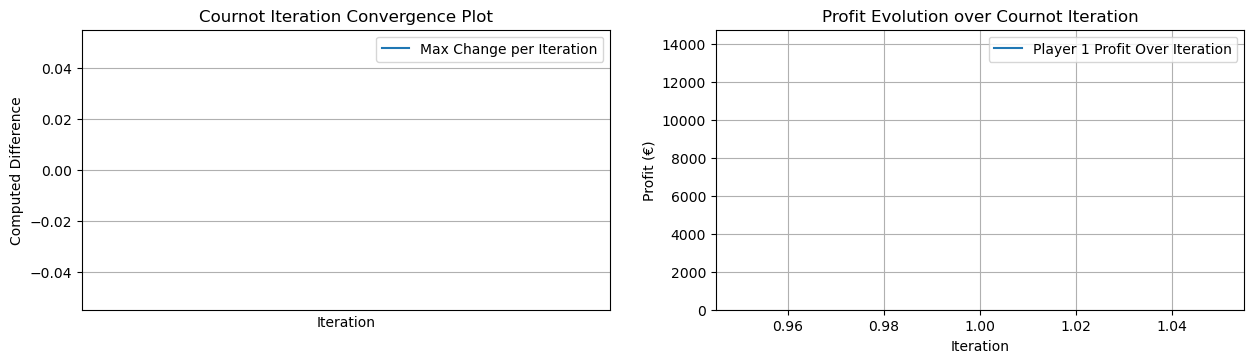

In [248]:
main(n_players=1)

Storage characteristics: 
          OC   Eta  E_max  Q_max                           Q_all
Player                                                         
A       5.0  0.85  160.0   30.0   [6.0, 12.0, 18.0, 24.0, 30.0]
B       5.0  0.85  330.0   60.0  [12.0, 24.0, 36.0, 48.0, 60.0]

Optimization was successful. 
It converged in 5 iterations.


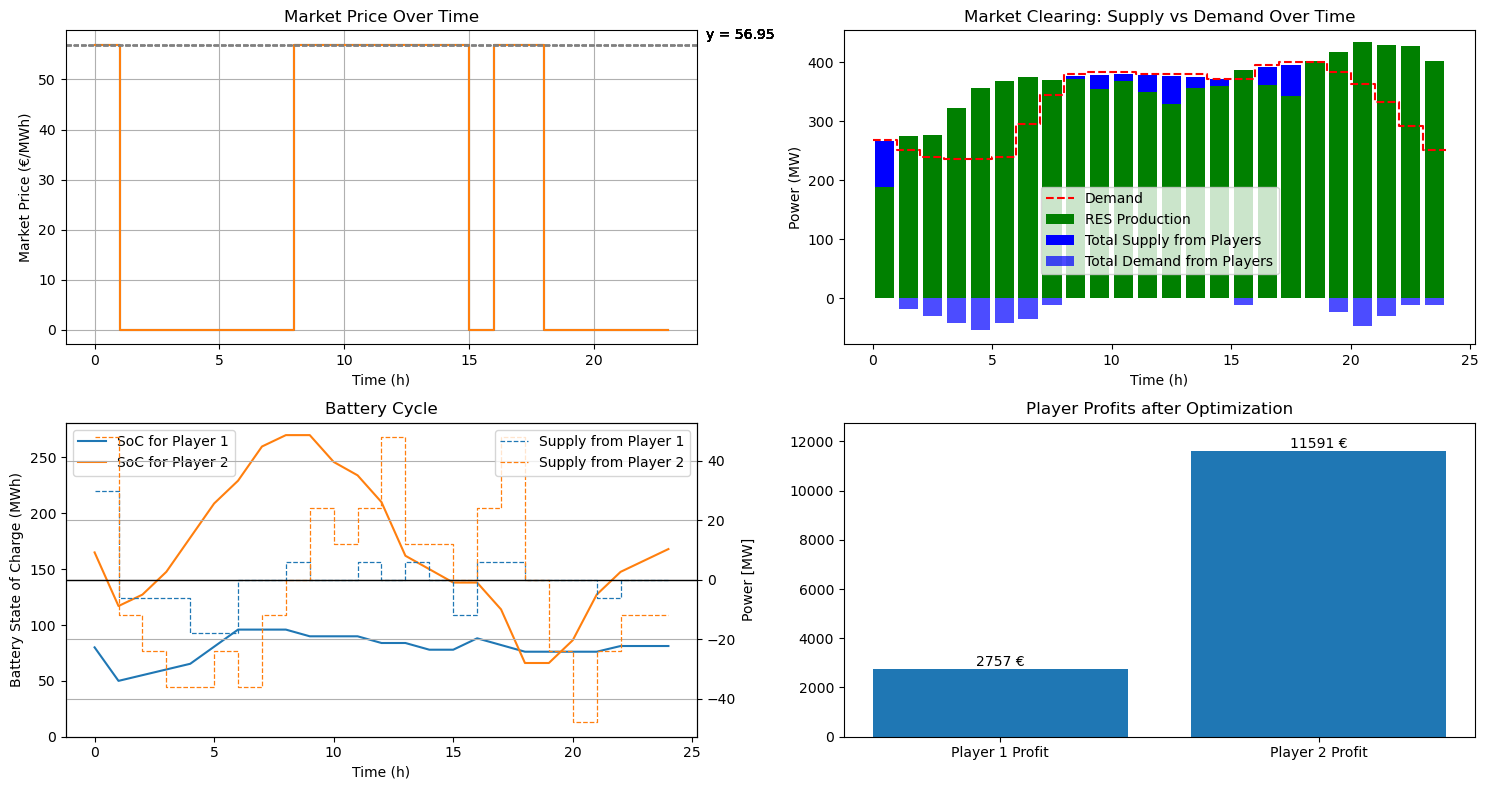

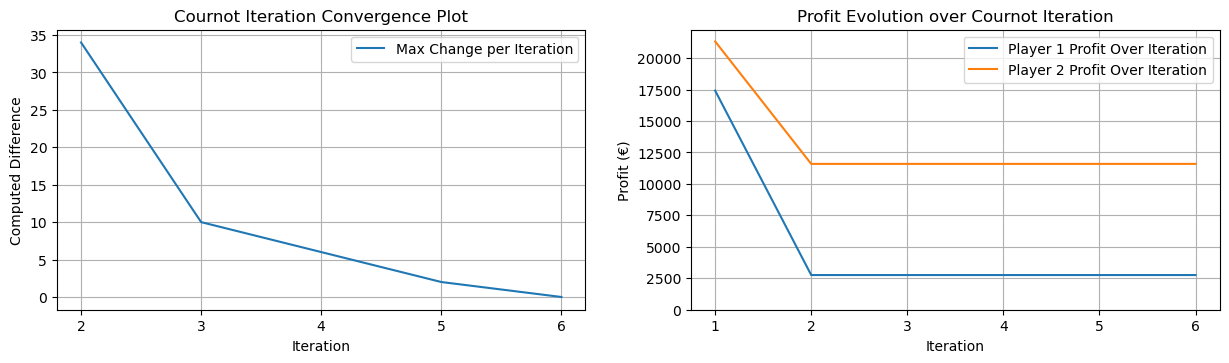

In [242]:
# Run Cournot game for profit maximization of each independent player
main(n_players=2)

Storage characteristics: 
          OC   Eta  E_max  Q_max                          Q_all
Player                                                        
A       5.0  0.85   50.0   10.0     [2.0, 4.0, 6.0, 8.0, 10.0]
B       5.0  0.85  100.0   20.0   [4.0, 8.0, 12.0, 16.0, 20.0]
C       5.0  0.85  150.0   30.0  [6.0, 12.0, 18.0, 24.0, 30.0]
D       5.0  0.85  200.0   40.0  [8.0, 16.0, 24.0, 32.0, 40.0]

Optimization was successful. 
It converged in 5 iterations.


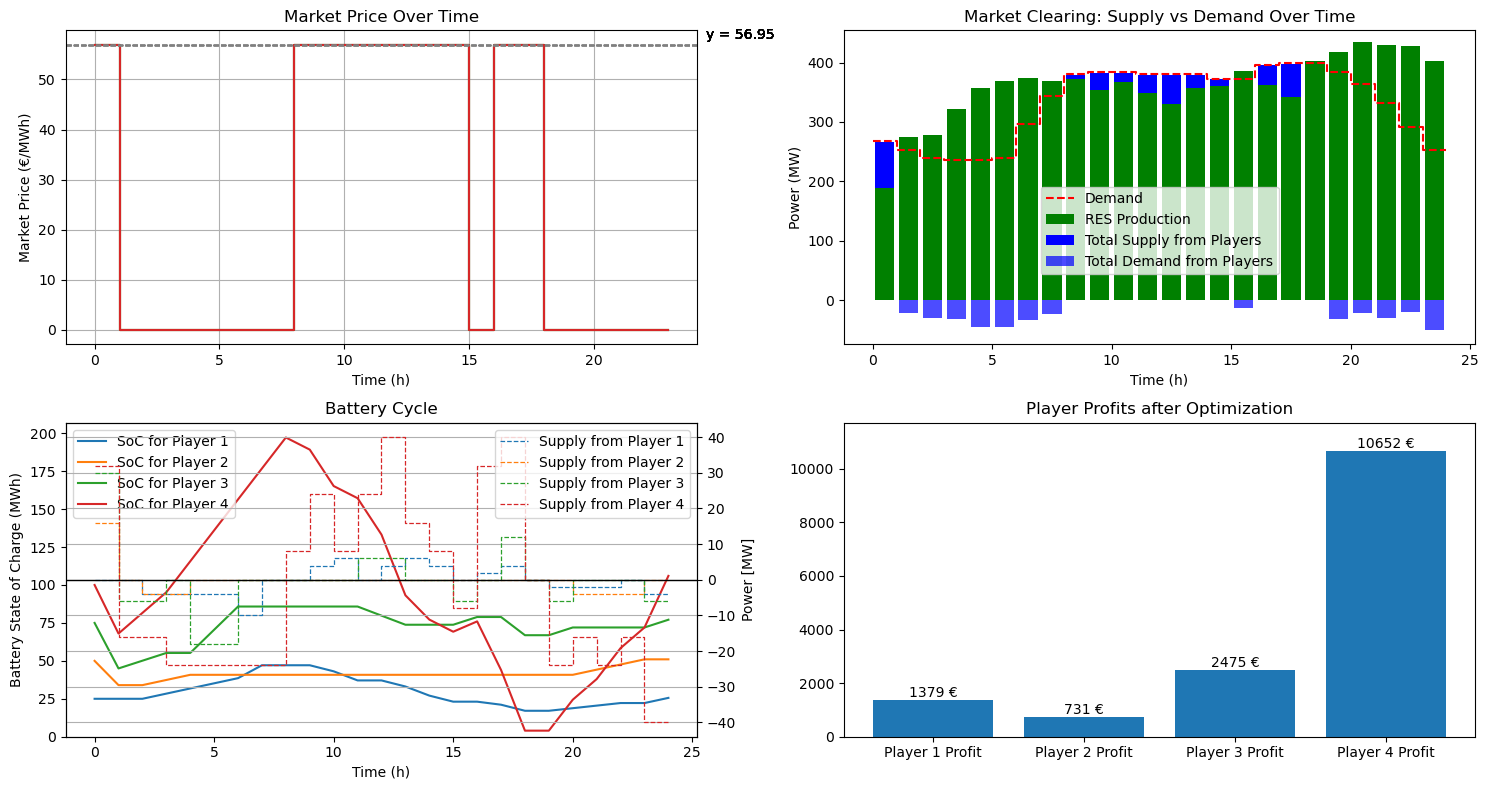

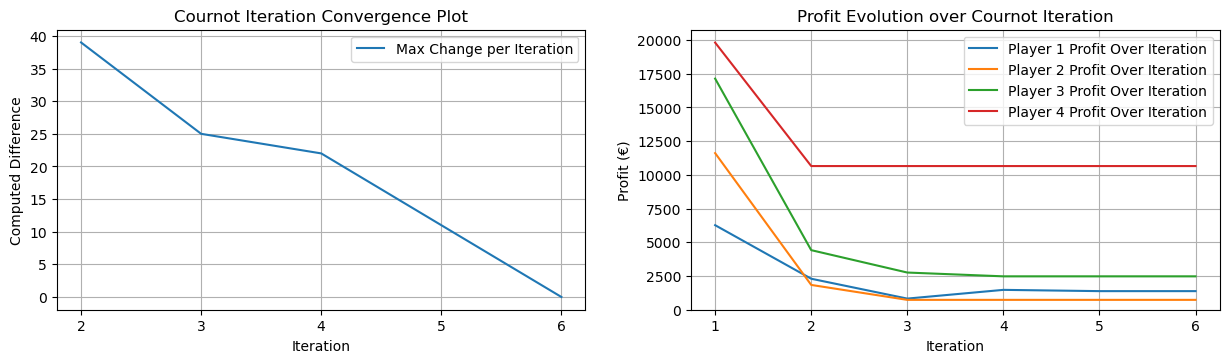

In [243]:
main(n_players=4)

Storage characteristics: 
          OC   Eta  E_max  Q_max                          Q_all
Player                                                        
A       5.0  0.85   20.0    0.0      [0.0, 0.0, 0.0, 0.0, 0.0]
B       5.0  0.85   50.0   10.0     [2.0, 4.0, 6.0, 8.0, 10.0]
C       5.0  0.85   50.0   10.0     [2.0, 4.0, 6.0, 8.0, 10.0]
D       5.0  0.85   70.0   10.0     [2.0, 4.0, 6.0, 8.0, 10.0]
E       5.0  0.85  120.0   20.0   [4.0, 8.0, 12.0, 16.0, 20.0]
F       5.0  0.85  170.0   30.0  [6.0, 12.0, 18.0, 24.0, 30.0]

Optimization was successful. 
It converged in 9 iterations.


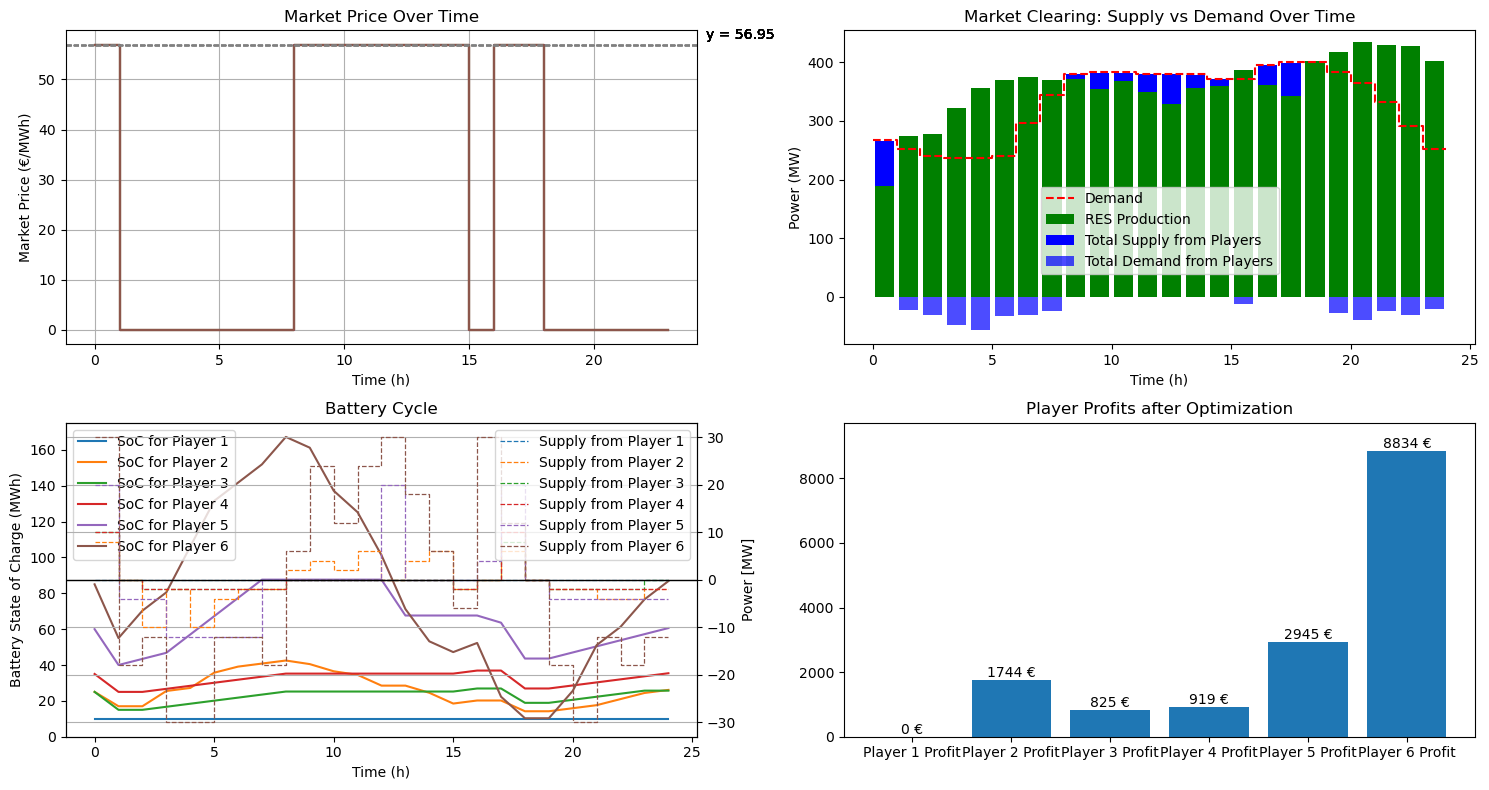

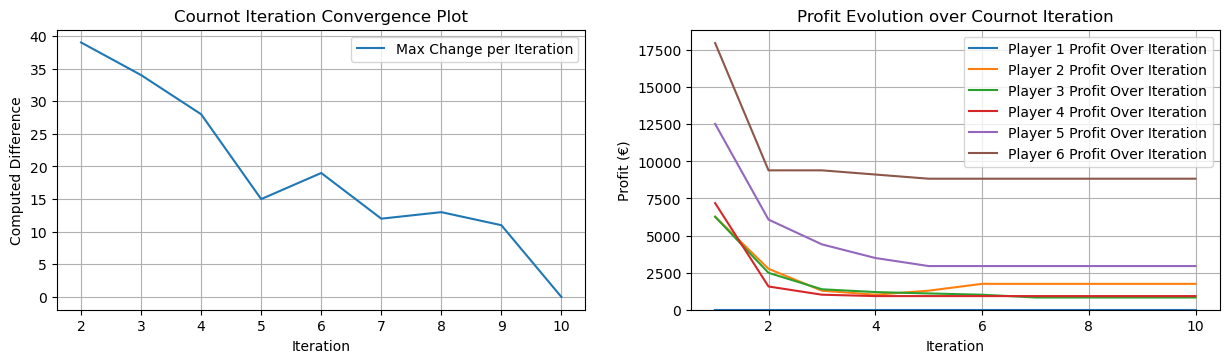

In [244]:
main(n_players=6)

Storage characteristics: 
          OC   Eta  E_max  Q_max                         Q_all
Player                                                       
A       5.0  0.85   20.0    0.0     [0.0, 0.0, 0.0, 0.0, 0.0]
B       5.0  0.85   20.0    0.0     [0.0, 0.0, 0.0, 0.0, 0.0]
C       5.0  0.85   50.0   10.0    [2.0, 4.0, 6.0, 8.0, 10.0]
D       5.0  0.85   50.0   10.0    [2.0, 4.0, 6.0, 8.0, 10.0]
E       5.0  0.85   50.0   10.0    [2.0, 4.0, 6.0, 8.0, 10.0]
F       5.0  0.85   70.0   10.0    [2.0, 4.0, 6.0, 8.0, 10.0]
G       5.0  0.85  100.0   20.0  [4.0, 8.0, 12.0, 16.0, 20.0]
H       5.0  0.85  120.0   20.0  [4.0, 8.0, 12.0, 16.0, 20.0]

Optimization was successful. 
It converged in 9 iterations.


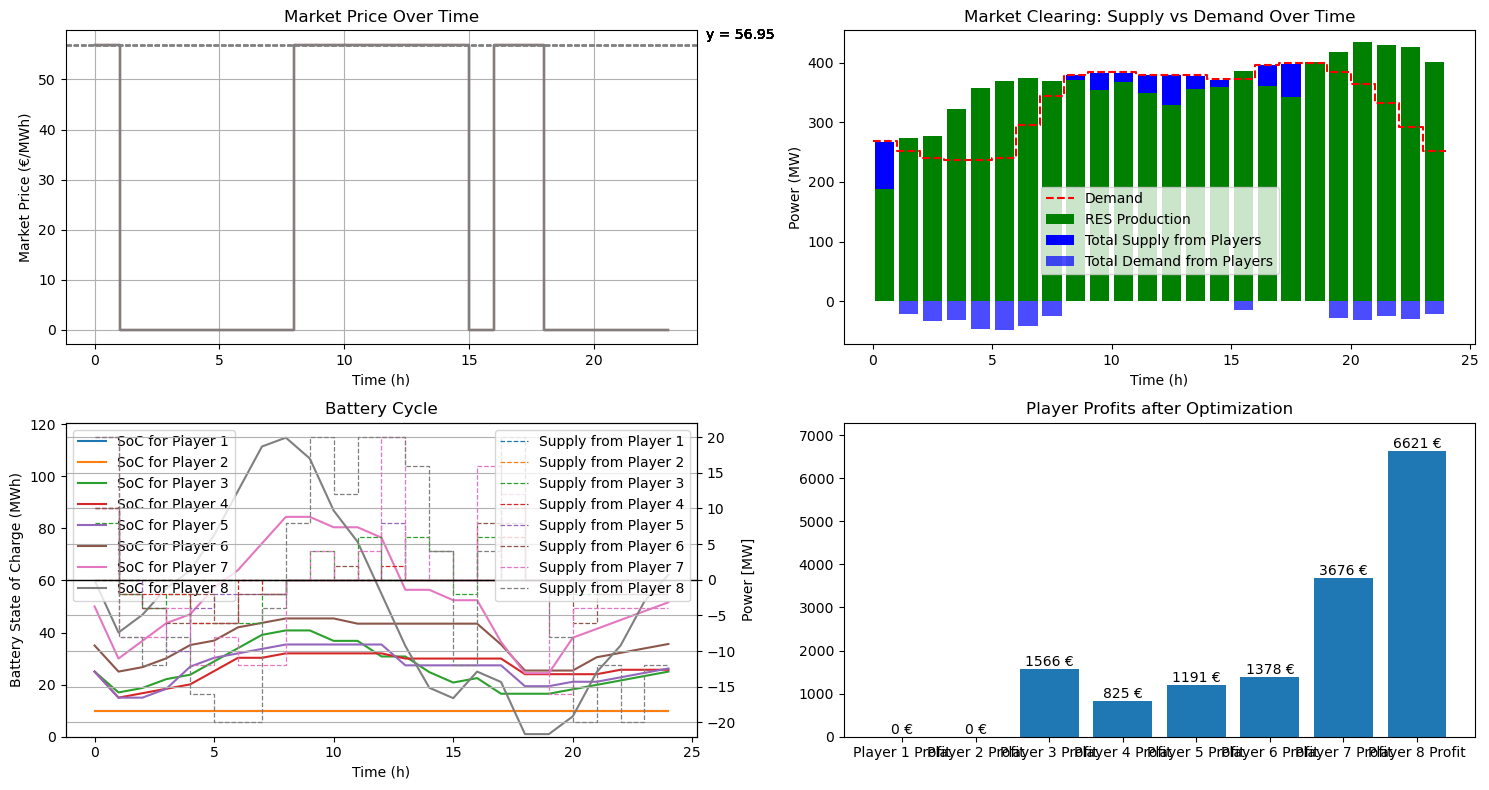

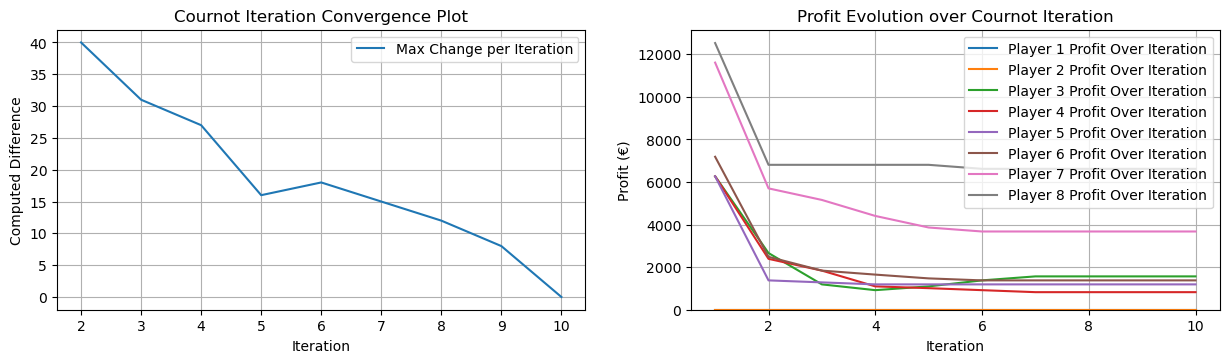

In [245]:
main(n_players=8)